Cargo las librerías necesarias:

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from datetime import datetime
import sklearn as sk
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression

Cargo los datos:

In [2]:
X_train = pd.read_csv('X_train_ns.csv')
del X_train['Unnamed: 0']
y_train = pd.read_csv('log_y_train.csv')
del y_train['Unnamed: 0']

# Dos consideraciones clave para la regresión

- No se deben añadir al resto de variables predictoras sus componentes principales como variables al entrenar una regresión, pues al ser combinaciones lineales de dichas variables se produciría **multicolinearidad perfecta**, lo cual impediría crear un buen modelo.


- Es muy importante crear la **división train/test al principio del proyecto**. Por ejemplo, si se calcula la PCA antes de hacer la división train/test, los problemas de la multicolinearidad perfecta no se verán con claridad en el conjunto de test, ya que el conjunto de test ha servido como conjunto de train para la PCA que produce dicha multicolinearidad. Por eso es importante crear la división train/test al principio del proyecto.

# Regresión

Empiezo por eliminar las componentes principales como variables del modelo:

In [3]:
X_train.columns

Index(['PCA2_v2', 'PCA2', 'Room Type', 'Accommodates', 'Cluster',
       'Host Total Listings Count', 'Bedrooms',
       'Calculated host listings count', 'Host Listings Count', 'Beds',
       'Guests Included', 'Zona', 'PCA4', 'Bathrooms', 'PCA5', 'Extra People',
       'PCA1', 'Host Response Rate', 'Minimum Nights',
       'Distancia al centroide', 'Amenities: Air conditioning', 'PCA8',
       'Availability 365', 'Calendar Updated', 'PCA3',
       'Amenities: Family/kid friendly', 'Availability 90', 'Availability 30',
       'Review Scores Location', 'Amenities: TV',
       'Review Scores Communication',
       'Amenities: translation missing: en.hosting_amenity_49',
       'Cancellation Policy', 'Availability 60', 'Review Scores Rating',
       'Review Scores Accuracy', 'Host Verifications',
       'Amenities: translation missing: en.hosting_amenity_50',
       'Review Scores Checkin', 'Reviews per Month',
       'Review Scores Cleanliness', 'PCA7', 'Review Scores Value', 'PCA6',
  

Elimino las componentes principales. No hace falta eliminar 'PCA2_v2' porque no es una combinación lineal de las variables.

In [4]:
Variables_sin_PCA = ['PCA2_v2', 'Room Type', 'Accommodates', 'Cluster',
       'Host Total Listings Count', 'Bedrooms',
       'Calculated host listings count', 'Host Listings Count', 'Beds',
       'Guests Included', 'Zona', 'Bathrooms', 'Extra People',
       'Host Response Rate', 'Minimum Nights',
       'Distancia al centroide', 'Amenities: Air conditioning',
       'Availability 365', 'Calendar Updated',
       'Amenities: Family/kid friendly', 'Availability 90', 'Availability 30',
       'Review Scores Location', 'Amenities: TV',
       'Review Scores Communication',
       'Amenities: translation missing: en.hosting_amenity_49',
       'Cancellation Policy', 'Availability 60', 'Review Scores Rating',
       'Review Scores Accuracy', 'Host Verifications',
       'Amenities: translation missing: en.hosting_amenity_50',
       'Review Scores Checkin', 'Reviews per Month',
       'Review Scores Cleanliness', 'Review Scores Value',
       'Maximum Nights', 'Amenities: Dryer', 'Amenities: Hair dryer',
       'Number of Reviews', 'Property Type', 'Amenities: Internet']

Después de crear una lista con las variables sin las componentes principales, redefino el conjunto de train para que sólo contenga las variables de esta lista:

In [5]:
X_train = X_train.loc[:,Variables_sin_PCA]

La librería que voy a emplear no añade Intercept, de modo que tengo que añadir yo una variable que actue de Intercept. Añadiré, en consecuencia, una variable 'Intercept' cuyo valor sea siempre 1:

In [6]:
X_train['Intercept'] = np.ones(X_train.shape[0])

Creo y entreno un modelo de regresión:

In [7]:
# OLS es Ordinary Least Squares:

modelo = sm.OLS(y_train, X_train)
resultados = modelo.fit()
print(resultados.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     545.2
Date:                Thu, 02 Jun 2022   Prob (F-statistic):               0.00
Time:                        22:51:51   Log-Likelihood:                -7636.7
No. Observations:               13286   AIC:                         1.536e+04
Df Residuals:                   13243   BIC:                         1.568e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

Hay muchos casos de correlación entre variables graves en este modelo. Por ejemplo, la variable 'Host Total Listings Count' y 'Host Listings Count'. Se puede deducir que es muy probable que tengan una alta correlación, además de midiendo su correlación, porque sus coefiecientes son casi idénticos pero opuestos (8.0372 y -7.9338), y porque los percentiles 0.025% y 0.975% de los intervalos de confianza de sus coeficientes también son casi idénticos pero opuestos: (-14.911, 30.985) para 'Host Total Listings Count' y (-30.882, 15.014) para 'Host Listings Count'.

No es el único caso de correlación grave.

Hay algunos errores (std err asociados a los coef, en la nomenclatura del output de la celda previa) que son muy altos en proporción a sus coeficientes. Esto puede ser también un síntoma de correlación multiple entre las variables predictivas.

Además, algunos p_valores son muy altos. Esto indica que las variables asociadas a ellos no son estadísticamente significativas para el modelo.

Una solución es aplicar backwards variable selection. Así eliminaré las variables menos importantes, y solucionaré los problemas de correlación entre variables predictoras y de existencia de variables no significativas. Otra forma de reducir estos problemas es emplear regularización.

Antes de aplicar backwards variable selection, voy a ver como de buenos son los resultados con este primer modelo:

In [8]:
print('El R cuadrado es',resultados.rsquared)

El R cuadrado es 0.6335664208888867


In [9]:
print('La media de los cuadrados de los errores es',resultados.ssr/X_train.shape[0])

La media de los cuadrados de los errores es 0.18483384584474963


A continuación, hago un gráfico de los precios reales frente a los precios predichos por el modelo de regresión. La línea roja marca las predicciones perfectas:

C:\Users\Usuario\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


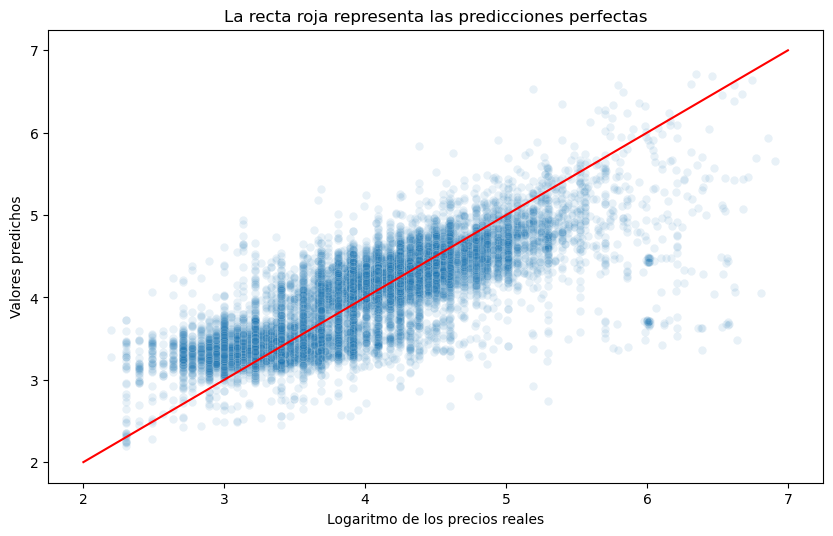

In [10]:
objetivo = list(list(np.array(y_train).reshape(1,-1))[0])

plt.figure(dpi=100, figsize=(10, 6))
sns.scatterplot(objetivo,list(resultados.predict(X_train)),alpha=0.1)
plt.plot((2,7),(2,7),color='Red')

plt.title("La recta roja representa las predicciones perfectas")
plt.xlabel('Logaritmo de los precios reales')
plt.ylabel('Valores predichos')
plt.show()

Los precios reales se acumulan en columnas porque la mayoría de los precios reales se acumulan en números enteros (y en particular en números acabados en 0, 9 y 5), a los cuales corresponden estas columnas.

# Backwards Variable Selection

A continuación voy a programar la primera mitad del algoritmo de Backward Variable Selection.

Dado un conjunto de variables, el algoritmo probará todos los modelos provenientes de aplicar regresión lineal al conjunto de variables iniciales menos una, para todas las variables que se pueden quitar.

Después, determinará cual de estos es el mejor comprobando su error sobre train. Esto es válido porque todos los modelos tienen el mismo número de variables.

A continuación, repetirá el proceso con el conjunto de variables seleccionado.

De esta forma creará una ristra de modelos, desde el modelo con todas las variables al modelo que sólo tiene el intercept, cada modelo de la ristra con una variable menos que el anterior.

De esta lista de modelos seleccionaré el mejor después, comprobando su error sobre un conjunto de validación. En este caso no podré usar el error sobre train, porque los modelos tendrán distinto número de variables.

In [11]:
def Backwards(Variables):
    '''
    Variables debe de ser una lista que contenga los nombres de las variables
    entre las cuales se realizará la selección.
    '''
    
    # Inicialización:
    
    N_Vars = len(Variables)
    
    D_Variables = {N_Vars: Variables}
    
    # Modelo completo (con todas las variables):
    
    D_Variables[N_Vars] = Variables
    
    # Modelos con menos variables:
    
    for k in [N_Vars-k-1 for k in range(1,N_Vars)]:
        
        L_Costes_temporal = []
        L_Variables_temporales = []
        
        for Var in Variables:
            
            # Se elimina una variable:
            
            Variables_temporales1 = list(Variables)
            Variables_temporales1.remove(Var)
            
            # Se entrena el modelo:
            
            Modelo = sm.OLS(y_train, X_train.loc[:,Variables_temporales1])
            Resultados = Modelo.fit()
            L_Costes_temporal.append(Resultados.ssr)
            L_Variables_temporales.append(Variables_temporales1)
            
        # Se comprueba que modelo dio el mejor resultado:
        
        Indice_menor_coste = L_Costes_temporal.index(min(L_Costes_temporal))
        
        # Se guardan las variables que dieron lugar al mejor resultado:
        
        print("Se retira la variable   ", Variables[Indice_menor_coste])
        
        Variables = L_Variables_temporales[Indice_menor_coste]
        
        D_Variables[k+1] = Variables
        
        
        
    return D_Variables

El orden en que las variables han sido retiradas, desde el modelo completo al modelo vacío, es el siguiente:

In [12]:
B_V = Backwards(list(X_train.columns))

Se retira la variable    Cluster
Se retira la variable    Maximum Nights
Se retira la variable    Host Response Rate
Se retira la variable    Availability 60
Se retira la variable    Availability 365
Se retira la variable    Cancellation Policy
Se retira la variable    Amenities: TV
Se retira la variable    Property Type
Se retira la variable    Host Listings Count
Se retira la variable    Review Scores Communication
Se retira la variable    Extra People
Se retira la variable    Minimum Nights
Se retira la variable    Amenities: translation missing: en.hosting_amenity_49
Se retira la variable    Distancia al centroide
Se retira la variable    Number of Reviews
Se retira la variable    Review Scores Value
Se retira la variable    Amenities: Family/kid friendly
Se retira la variable    Host Verifications
Se retira la variable    Review Scores Rating
Se retira la variable    Guests Included
Se retira la variable    Zona
Se retira la variable    Availability 90
Se retira la variable    PCA

El modelo seleccionado para cada número de variables queda guardado en el siguiente diccionario, que a cada número de variables le asocia la lista de variables escojida de entre las de ese tamaño. El modelo más grande tiene 51 variables contando el intercept, y el más pequeño sólo tiene una variable contando el intercept (aunque lo normal es no contarlo como variable):

In [13]:
B_V

{43: ['PCA2_v2',
  'Room Type',
  'Accommodates',
  'Cluster',
  'Host Total Listings Count',
  'Bedrooms',
  'Calculated host listings count',
  'Host Listings Count',
  'Beds',
  'Guests Included',
  'Zona',
  'Bathrooms',
  'Extra People',
  'Host Response Rate',
  'Minimum Nights',
  'Distancia al centroide',
  'Amenities: Air conditioning',
  'Availability 365',
  'Calendar Updated',
  'Amenities: Family/kid friendly',
  'Availability 90',
  'Availability 30',
  'Review Scores Location',
  'Amenities: TV',
  'Review Scores Communication',
  'Amenities: translation missing: en.hosting_amenity_49',
  'Cancellation Policy',
  'Availability 60',
  'Review Scores Rating',
  'Review Scores Accuracy',
  'Host Verifications',
  'Amenities: translation missing: en.hosting_amenity_50',
  'Review Scores Checkin',
  'Reviews per Month',
  'Review Scores Cleanliness',
  'Review Scores Value',
  'Maximum Nights',
  'Amenities: Dryer',
  'Amenities: Hair dryer',
  'Number of Reviews',
  'Propert

A continuación voy a determinar cúal de estos 43 modelos es el óptimo, comparando sus resultados frente a un conjunto de validación. Para ello creo la siguiente función. El código esta comentado con los detalles del programa:

In [14]:
def Seleccion(Diccionario,N_Var,semilla):
    '''
    El input es el diccionario que devolvio la función Backwards,
    el número de variables y la semilla para el generador
    de conjuntos de entrenamiento y validación pseudoaleatorios.
    '''
    
    # Separo un conjunto de validación y un conjunto de entrenamiento:
    
    X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train,
                                                    test_size=0.1,random_state=semilla)
    
    # Inicializo un vector de costes:
    
    Costes = []
    
    # Para cada número de variables posible (de 1 a 51 en este caso):
    
    for n in range(1,N_Var+1):
        
        # Entreno, de los modelos (conjuntos de variables) del diccionario que
        # se suministro de input a la función,
        # el que tiene el número de variables n (n es el valor de esta iteración del bucle).
        
        # Entreno el modelo con el conjunto de entrenamiento seleccionado antes en esta función.
        
        Modelo = sm.OLS(y_train2, X_train2.loc[:,Diccionario[n]])
        Resultado = Modelo.fit()
        
        # Empleo el modelo para realizar predicciones para el conjunto de validación que generé.
        
        Pred_val = Resultado.predict(X_val.loc[:,Diccionario[n]])
        
        # Guardo en el vector de costes el error asociado a las predicciones que acabo de hacer:
        
        Costes.append(sk.metrics.mean_squared_error(Pred_val, y_val))
        
    # El coste más bajo tiene el índice:
        
    Indice_menor_coste = Costes.index(min(Costes))
    
    print('El coste más bajo es', min(Costes))
    
    # Realizo un gráfico con los costes por número de variables:
    
    sns.lineplot(list(range(1,N_Var+1)),Costes)
    plt.xlabel('Número de variables')
    plt.ylabel('Coste sobre validación (MSE)')
    plt.show()
    
    return Diccionario[Indice_menor_coste+1]

Empleo la función anterior. Como los resultados dependen del conjunto de validación elegido de manera pseudoaleatoria, repito varias veces el proceso con distintas semillas, para ver si los resultados son estables, o tienen excesiva varianza para ser fiables.

El coste más bajo es 0.17214945110136412


C:\Users\Usuario\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


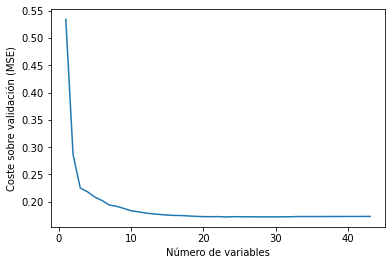

In [15]:
Seleccion_Optima = Seleccion(B_V,43,10)

In [16]:
print('El número óptimo de variables es',len(Seleccion_Optima))

El número óptimo de variables es 23


El coste más bajo es 0.17177071172669958


C:\Users\Usuario\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


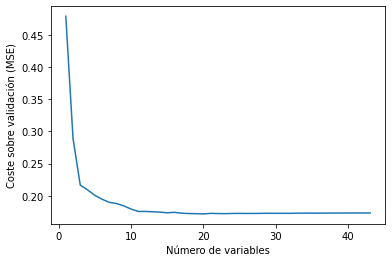

In [17]:
Seleccion_Optima = Seleccion(B_V,43,1000)

In [18]:
print('El número óptimo de variables es',len(Seleccion_Optima))

El número óptimo de variables es 20


El coste más bajo es 0.16487479962281215


C:\Users\Usuario\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


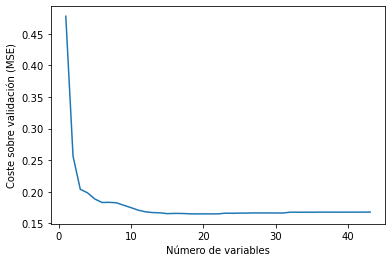

In [19]:
Seleccion_Optima = Seleccion(B_V,43,100)

In [20]:
print('El número óptimo de variables es',len(Seleccion_Optima))

El número óptimo de variables es 19


Los resultados son similares en todos los casos. Entreno un modelo con la mejor selección de variables posible (de acuerdo al algoritmo backwards):

In [21]:
modelo = sm.OLS(y_train, X_train.loc[:,Seleccion_Optima])
resultados = modelo.fit()
print(resultados.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     1262.
Date:                Thu, 02 Jun 2022   Prob (F-statistic):               0.00
Time:                        22:52:06   Log-Likelihood:                -7677.0
No. Observations:               13286   AIC:                         1.539e+04
Df Residuals:                   13267   BIC:                         1.553e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

Ahora todos los coefiecientes son estadísticamente significativos, y los errores son muy pequeños en relación a sus coeficientes asociados.

In [22]:
resultados.ssr/X_train.shape[0]

0.18596111891807948

La media de los cuadrados de los errores valía antes 0.18483384584474966, luego el emplear menos variables no ha empeorado las predicciones practicamente nada. También el R cuadrado se mantiene practicamente fijo.

En términos generales, si se puede reducir el número de variables de un modelo sin reducir su capacidad predictiva, es una buena idea hacerlo, ya que así se reduce el riesgo de sobreajuste.

Además, he eliminado los problemas de colinearidad, y de coeficientes no significativos.

En consecuencia, determino que este modelo es preferible al modelo con todas las variables

C:\Users\Usuario\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


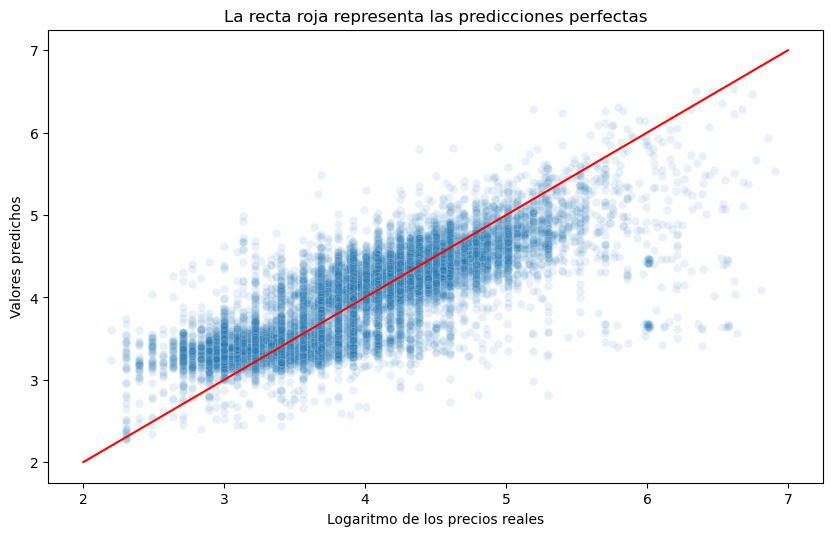

In [23]:
objetivo = list(list(np.array(y_train).reshape(1,-1))[0])

plt.figure(dpi=100, figsize=(10, 6))
sns.scatterplot(objetivo,list(resultados.predict(X_train.loc[:,Seleccion_Optima])),alpha=0.1)
plt.plot((2,7),(2,7),color='Red')

plt.title("La recta roja representa las predicciones perfectas")
plt.xlabel('Logaritmo de los precios reales')
plt.ylabel('Valores predichos')
plt.show()

El gráfico de predicciones frente a valores reales es similar al del modelo inicial.

Los parámetros del nuevo modelo son:

In [24]:
resultados.params

Room Type                                                0.338321
Accommodates                                             0.184202
Host Total Listings Count                                0.101899
Bedrooms                                                 0.121087
Calculated host listings count                          -0.074690
Beds                                                    -0.076640
Bathrooms                                                0.058794
Amenities: Air conditioning                              0.054237
Calendar Updated                                         0.078865
Availability 30                                          0.080182
Review Scores Location                                   0.089576
Amenities: translation missing: en.hosting_amenity_50   -0.023706
Review Scores Checkin                                   -0.078476
Reviews per Month                                       -0.056156
Review Scores Cleanliness                                0.025445
Amenities:

Cómo las variables están estandarizadas (las estandarize en el Notebook 4), el valor absoluto de cada coeficiente es representativo de su importancia en el modelo.

Voy a comparar estos valores con los determinados por la información mutua:

In [25]:
def Información_Mutua(X, y):
    '''
    X debe ser un DataFrame con las variables predictivas.
    y debe contener la variable objetivo.
    '''
    # Calculo el mutual information,
    # y ordeno las variables según el mutual information:
    
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [26]:
I_M = Información_Mutua(X_train.loc[:,Seleccion_Optima], y_train)
I_M[::]

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Room Type                                                0.371565
Accommodates                                             0.369864
Bedrooms                                                 0.237650
Calculated host listings count                           0.236758
Host Total Listings Count                                0.236705
Beds                                                     0.216116
Bathrooms                                                0.122063
Amenities: Air conditioning                              0.094970
Calendar Updated                                         0.085912
Availability 30                                          0.064695
Review Scores Location                                   0.060401
Review Scores Cleanliness                                0.046098
Amenities: translation missing: en.hosting_amenity_50    0.044460
Reviews per Month                                        0.044048
Review Scores Checkin                                    0.042900
Amenities:

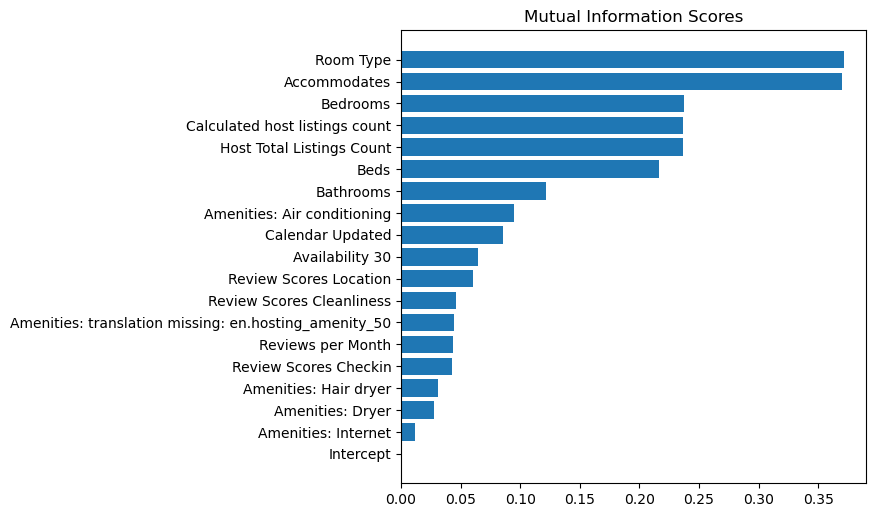

In [27]:
plt.figure(dpi=100, figsize=(6, 6))
plot_mi_scores(I_M)

El gráfico previo muestra las importancias asignadas por la información mutua a las variables, y el gráfico siguiente muestra las importancias asignadas por el modelo de regresión a las variables. En ambos casos sólo se muestran las variables presentes en el modelo de regresión tras aplicar Backwards variable selection.

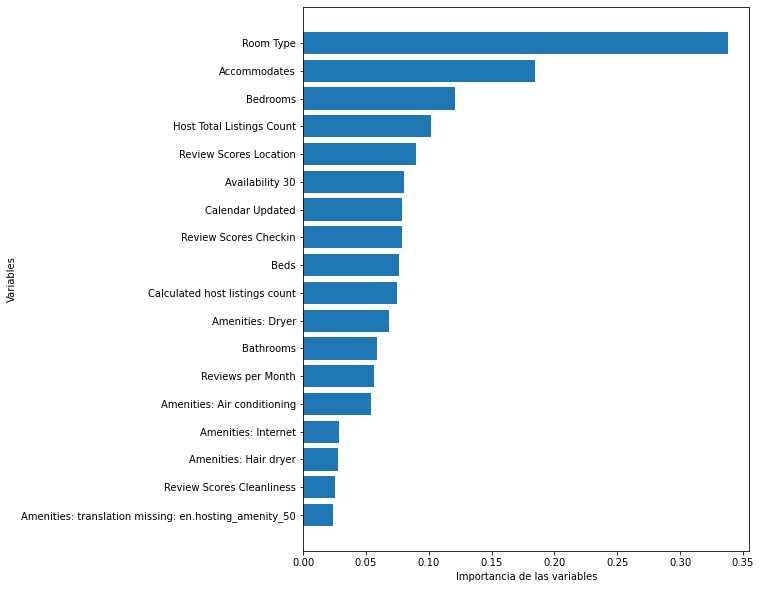

In [28]:
plt.figure(figsize=(8, 10))
plt.barh(range(18), abs(resultados.params[np.argsort(abs(resultados.params))])[0:18])
plt.yticks(np.arange(18),resultados.params.index[np.argsort(abs(resultados.params))][0:18])
plt.xlabel('Importancia de las variables')
plt.ylabel('Variables')
plt.show()

Se puede ver que ambos gráficos son muy diferentes. Esto se debe a que la regresión parte de la hipótesis de que las variables predictoras tienen una relación lineal con el objetivo (hipótesis que no existe en el caso de la información mutua).

En la realidad, la relación entre la variable predictora y el objetivo casi nunca es lineal. Aun así, los modelos de regresión, precisamente gracias a esta simplificación de la realidad que realizan (por medio de la hipótesis de linealidad), tienen un riesgo de sobreajuste menor a otros modelos, y padecen en menor medida de la maldición de la dimensionalidad (gracias a su simplicidad).

En consecuencia, la regresión lineal no da importancia a variables que, si bien si contienen información importante sobre el precio, no tiene relación lineal con este.

Por eso, el gráfico de importancia de las variables es muy distinto según la información mutua y según la regresión.

A continuación pongo en un gráfico los coeficientes (con sus signos):

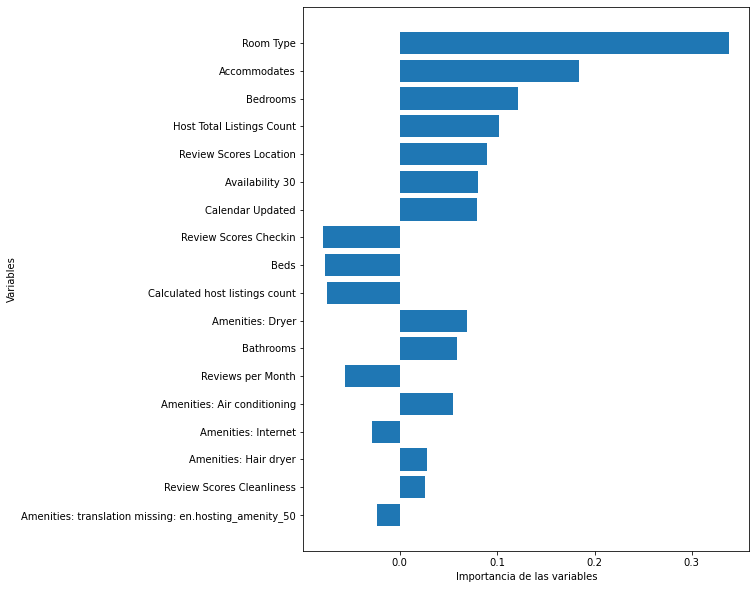

In [29]:
plt.figure(figsize=(8, 10))
plt.barh(range(18), (resultados.params[np.argsort(abs(resultados.params))])[0:18])
plt.yticks(np.arange(18),resultados.params.index[np.argsort(abs(resultados.params))][0:18])
plt.xlabel('Importancia de las variables')
plt.ylabel('Variables')
plt.show()

Repito el gráfico, pero esta vez, en vez de ordenar las variables por el valor absoluto de sus coeficientes, las ordeno de mayor a menor según sus coeficientes (con signos):

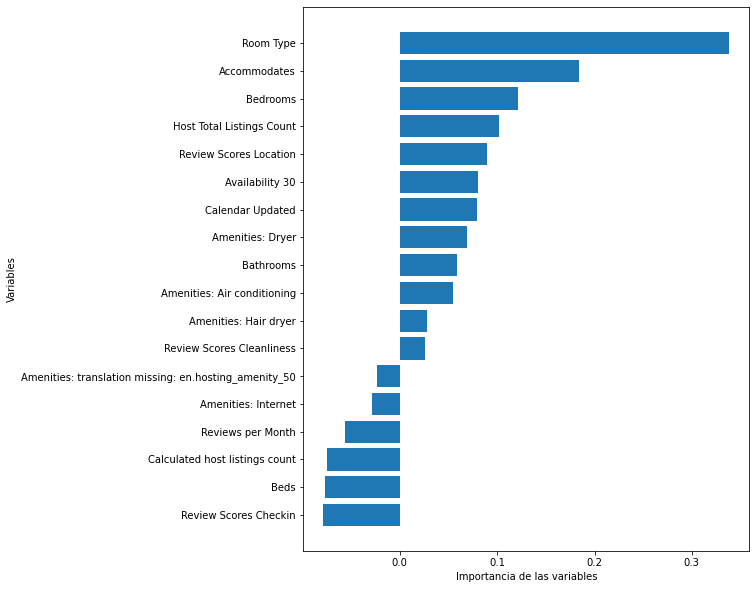

In [30]:
plt.figure(figsize=(8, 10))
plt.barh(range(18), (resultados.params[np.argsort((resultados.params))])[0:18])
plt.yticks(np.arange(18),resultados.params.index[np.argsort((resultados.params))][0:18])
plt.xlabel('Importancia de las variables')
plt.ylabel('Variables')
plt.show()

La primera interpretación en la que se puede pensar, a la vista de este gráfico, es que aquellas variables con coeficientes negativos están asociadas a un menor precio (a mayor sea el valor de la variable, menor será el precio), y que aquellas variables con un coeficiente positivo están asociadas a un precio mayor (a mayor sea el valor de la variable, mayor será el precio).

Esto no es necesariamente así.

Por ejemplo, la variable Beds tiene un coeficiente negativo, a pesar de que las casas más caras tienen más camas, como se puede ver en el siguiente gráfico:

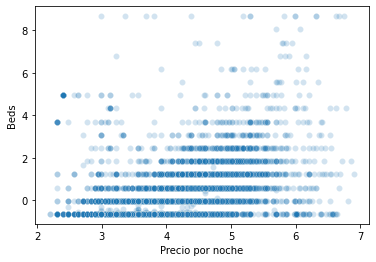

In [31]:
sns.scatterplot(x=objetivo,
                y=list(np.array(X_train['Beds'])),alpha=0.2)
plt.xlabel('Precio por noche')
plt.ylabel('Beds')
plt.show()

De hecho, la correlación del precio por noche y el número de dormitorios es positiva:

In [32]:
np.corrcoef(objetivo,list(np.array(X_train['Beds'])))[0,1]

0.44342062726988085

La correlación entre el precio y Beds es 0.48452135, y es positiva. Sin embargo, su coeficiente asociado en la regresión es negativo.

Hay varios motivos por los que esto puede ser así, pero el principal es que la variable Beds esta correlacionada con otras variables de signo positivo, como Bedrooms. Esto hace que los pisos con más camas (Beds) también tengan un mayor valor en otras variables que sí tienen signo positivo (como Bedrooms), y en consecuencia el modelo predice, de media, un mayor valor para los pisos con más camas, a pesar de que el coeficiente asociado a Beds es negativo.

Si queremos saber si una variable afecta positiva o negativamente, se deben hacer regresiones para cada variable por separado, para evitar interacciones de este estilo. También se puede ver gráficamente en el Notebook de Gráficos.

Para más información sobre los problemas asociados a la interpretación de los coeficientes de las regresiones, adjunto el siguiente vídeo, en el que Robert Tibshirani trata este tema a partir del minuto 2:36, en las partes del vídeo "Interpreting regression coefficients", "The woes of (interpreting) regression coefficients" y "Two quotes by famous Statisticians".

In [33]:
from IPython.display import HTML
HTML('<iframe width="420" height="345" src="https://www.youtube.com/embed/yzQHONabWhs?autoplay=1" frameborder="0" allowfullscreen></iframe>')

C:\Users\Usuario\anaconda3\lib\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


En el caso de que el vídeo anterior no se carge, [aquí hay un link al vídeo.](https://www.youtube.com/watch?v=yzQHONabWhs)

Guardo las variables seleccionadas como óptimas en un csv:

In [34]:
Seleccion_Optima = pd.Series(Seleccion_Optima)

In [35]:
#pd.Series(Seleccion_Optima).to_csv('Variables_regresión_Backwards.csv')